Figure 1

In [1]:
import cv2
from matplotlib import pyplot as plt

import final_project.config as c

In [2]:
# GLOBALS:

# Change global thresholds:
NN_Ratio = 0.75
InlierVerticalThreshold = 1

# Change cv2 objects:
Detector = cv2.SIFT_create()
Matcher = cv2.FlannBasedMatcher(indexParams=dict(algorithm=0, trees=5), searchParams=dict(checks=50))

InlierColor, OutlierColor = "gold", "cyan"

In [3]:
def find_inliers_and_outliers(fr_idx: int):
    img_l, img_r = c.read_images(fr_idx)
    kps_l, descs_l = Detector.detectAndCompute(img_l, None)
    kps_r, descs_r = Detector.detectAndCompute(img_r, None)

    # find all matches
    if c._SHOULD_USE_2NN:
        nn_matches = Matcher.knnMatch(descs_l, descs_r, 2)
        all_matches = [first for (first, second) in nn_matches if first.distance / second.distance <= NN_Ratio]
    else:
        all_matches = Matcher.match(descs_l, descs_r)
    match_idxs_left = [m.queryIdx for m in all_matches]  # indices of matches from $features1
    match_idxs_right = [m.trainIdx for m in all_matches]  # indices of matches from $features2
    match_idxs = list(zip(match_idxs_left, match_idxs_right))

    # extract inliers
    inlier_list, outlier_list = [], []
    for idx_l, idx_r in match_idxs:
        kp_l, kp_r = kps_l[idx_l], kps_r[idx_r]
        xl, yl = kp_l.pt
        xr, yr = kp_r.pt
        if xl <= xr or abs(yl - yr) >= InlierVerticalThreshold:
            # this match is triangulated *behind* the cameras
            # or it is not on the Epi-Polar line
            outlier_list.append([xl, yl, xr, yr])
        else:
            inlier_list.append([xl, yl, xr, yr])
    return inlier_list, outlier_list

<Figure size 432x288 with 0 Axes>

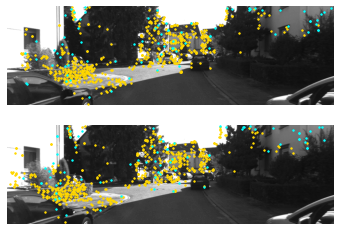

<Figure size 648x432 with 0 Axes>

In [5]:
# Change only this line!
frame_idx = 126  # this frame is in a loop with frame 1554

img_l, img_r = c.read_images(frame_idx)
inliers, outliers = find_inliers_and_outliers(frame_idx)

plt.clf()
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
fig = plt.figure(figsize=(9, 6))
axes[0].imshow(img_l, cmap='gray', vmin=0, vmax=255)
axes[0].scatter([inl[0] for inl in inliers], [inl[1] for inl in inliers], s=2, c=InlierColor, marker='o')
axes[0].scatter([olr[0] for olr in outliers], [olr[1] for olr in outliers], s=2, c=OutlierColor, marker='o')
axes[0].axis('off')

axes[1].imshow(img_l, cmap='gray', vmin=0, vmax=255)
axes[1].scatter([inl[2] for inl in inliers], [inl[3] for inl in inliers], s=2, c=InlierColor, marker='o')
axes[1].scatter([olr[2] for olr in outliers], [olr[3] for olr in outliers], s=2, c=OutlierColor, marker='o')
axes[1].axis('off')
plt.show()